In [2]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from scipy.stats import poisson
import warnings; warnings.simplefilter('ignore')
import numpy as np
from cycler import cycler
from copy import deepcopy
from hmmlearn import hmm
from sklearn import mixture
from matplotlib import rc
rc('text', usetex=True)

In [3]:
class GMM_model:
    def __init__(self,numclasses):
        self.numclasses = numclasses
        
    def E_step(self,datasets):
        N = datasets.shape[1]
        numsets = datasets.shape[0]
        gamma_ = np.zeros((numsets,N,self.numclasses))
        for k in range(self.numclasses):
            gamma_[:,:,k] = 1e-20 + self.weights_[:,k][:,np.newaxis]*stats.multivariate_normal.pdf(datasets,mean = self.means_[k],cov = self.covars_[k])
        gamma_ = gamma_/np.sum(gamma_,axis=2)[:,:,np.newaxis]
        return gamma_
    
    def M_step(self,datasets,gamma_):
        for k in range(self.numclasses):
            Nk = np.sum(gamma_[:,:,k])
            self.means_[k] = np.sum(np.sum(gamma_[:,:,k][:,:,None]*datasets,axis=1),axis=0)/Nk
            outerprod = (datasets - self.means_[k])[:,:,:,None]*(datasets - self.means_[k])[:,:,None,:]
            self.covars_[k] = np.sum(np.sum(gamma_[:,:,k][:,:,None,None]*outerprod,axis=1),axis=0)/Nk
            self.weights_ = np.sum(gamma_,axis=1)/self.N
            
    def LL(self,datasets):
        N = datasets.shape[1]
        numsets = datasets.shape[0]
        temp = np.zeros((numsets,N))
        for k in range(self.numclasses):
            temp += self.weights_[:,k][:,None]*stats.multivariate_normal.pdf(datasets,mean = self.means_[k],cov = self.covars_[k])
        LL = np.mean(np.log(temp + 1e-80))
        return -LL
        
    def solve(self,datasets):
        self.numsets= len(datasets)
        self.dim = datasets.shape[2]
        self.N = datasets.shape[1]
        self.means_ = np.zeros((self.numclasses,self.dim))
        self.covars_ = np.zeros((self.numclasses, self.dim,self.dim))
        self.weights_ = np.zeros((self.numsets,self.numclasses))
        
        datasets_flat = np.reshape(datasets,(-1,datasets.shape[2]))
        covar = np.cov(datasets_flat, rowvar = False)
        mean = np.mean(datasets_flat, axis = 0)
        
        numinits = 20
        means_init = np.zeros((numinits,self.numclasses,self.dim))
        covars_init = np.zeros((numinits,self.numclasses,self.dim,self.dim))
        weights_init = np.zeros((numinits,self.numsets,self.numclasses))
        LL_init = np.zeros(numinits)
        for init_ in range(numinits):
            for i in range(self.numclasses):
                means_init[init_][i] = np.random.multivariate_normal(mean,covar)
                covars_init[init_][i] = deepcopy(covar)

            for j in range(self.numsets):
                weights_init[init_][j] = np.random.dirichlet(5*np.ones(self.numclasses))
            self.means_ = means_init[init_]
            self.covars_ = covars_init[init_]
            self.weights_ = weights_init[init_]
            LL_init[init_] = self.LL(datasets)
        best = np.argmin(LL_init)
        self.means_ = means_init[best]
        self.covars_ = covars_init[best]
        self.weights_ = weights_init[best]
            
        LL_curr = self.LL(datasets)
        LL_prev = 0
        print("Initial negative log-likelihood per sample = %.4f" %LL_curr)
        num = 0
        while np.abs(LL_curr - LL_prev) > 1e-4:
            gamma_= self.E_step(datasets)
            self.M_step(datasets,gamma_)
            LL_prev = LL_curr
            LL_curr = self.LL(datasets)
            num += 1
            #print(LL_curr)
        print("Final negative log-likelihood per sample = %.4f" %LL_curr)
        print("Number of iterations = %d" %num)
        
    def _compute_posterior(self,y,set_index):
        post = np.zeros(self.numclasses)
        for k in range(self.numclasses):
            post[k] = self.weights_[set_index][k]*self._compute_likelihood(y,k)
        return post/np.sum(post)
        
    def _compute_likelihood(self,y,s):
        return stats.multivariate_normal.pdf(y,mean = self.means_[s],cov = self.covars_[s])
    
    def _compute_log_likelihood(self,data):
        Y = np.zeros((len(data),self.numclasses))
        for k in range(self.numclasses):
            Y[:,k] = np.log(stats.multivariate_normal.pdf(data,mean = self.means_[k],cov = self.covars_[k]) + 1e-80)
        return Y
    def score(self,dataset,set_index):
        temp = np.zeros(len(dataset))
        for k in range(self.numclasses):
            temp += self.weights_[set_index,k]*stats.multivariate_normal.pdf(dataset,mean = self.means_[k],cov = self.covars_[k])
        LL = np.sum(np.log(temp + 1e-80))
        return LL
        
    def _generate_sample_from_state(self,s):
        return np.random.multivariate_normal(self.means_[s],self.covars_[s])
    
    def _read_params(self,means_,covars_,weights_):
        self.numclasses = means_.shape[0]
        self.means_ = means_
        self.covars_ = covars_
        self.weights_ = weights_
        
    def _save_params(self,filename):
        np.save(filename + "_means",self.means_)
        np.save(filename + "_covars",self.covars_)
        np.save(filename + "_weights",self.weights_)
        
def compute_transmat(Y):
    #Initialize transition matrices
    numclasses = Y.shape[1]
    transmat_ = np.zeros((numclasses,numclasses))
    stationary_probs_ = np.random.dirichlet(5*np.ones(numclasses))
    for k in range(numclasses):
        transmat_[k] = np.random.dirichlet(5*np.ones(numclasses))
    for k in range(numclasses):
        for iter_ in range(50):
            stationary_probs_ = np.einsum('i,ij', stationary_probs_, transmat_)
            
    numiter = 100
    LLs = np.zeros(numiter)
    
    #compute alphas
    for iter_ in range(numiter):
        N = Y.shape[0]
        alphas = np.zeros((N,numclasses))
        norms = np.zeros(N)
        for i in range(N):
            if i == 0:
                alphas[i] = stationary_probs_*Y[i] 
            else:  
                alphas[i] = np.einsum('i,ij',alphas[i-1],transmat_)*Y[i]
            norms[i] = np.sum(alphas[i])
            alphas[i] /= norms[i]

        
        LLs[iter_] = -np.sum(np.log(norms + 1e-20))/N
        #print(iter_,LLs[iter_])
        if iter_ > 5 and np.abs(LLs[iter_] - LLs[iter_-1]) < 1e-4:
            break
        #compute betas
        betas = np.zeros((N,numclasses))
        for i in range(N-1,-1,-1):
            if i == N-1:
                betas[i] = 1.0
            else:  
                betas[i] = np.einsum('j,ij,j', betas[i+1], transmat_,Y[i+1])
            betas[i] /= np.sum(betas[i])

        #compute states
        gamma_ = np.zeros((N,numclasses))
        for i in range(N):
            gamma_[i] = alphas[i]*betas[i]/np.sum(alphas[i]*betas[i])

        #compute transitions:
        xi_ = np.zeros((N,numclasses,numclasses))
        for j in range(numclasses):
            for k in range(numclasses):
                xi_[1:,j,k] = alphas[:-1,j]*transmat_[j,k]*Y[1:,k]*betas[1:,k]
        xi_ /= np.sum(xi_,axis=(1,2))[:,None,None]

        #update transmat_
        for k in range(numclasses):
            transmat_[:,k] = np.sum(xi_[1:,:,k],axis=0)/np.sum(gamma_[:-1],axis=0)
        stationary_probs_ = gamma_[0]
        for k in range(numclasses):
            transmat_[k] /= np.sum(transmat_[k])
            
        for k in range(numclasses):
            for iter_ in range(50):
                stationary_probs_ = np.einsum('i,ij', stationary_probs_, transmat_)
    
    return transmat_,stationary_probs_

def test_for_markovianity(Y,w_dict,eps,p_d,transmat_, stationary_probs_):
    lengths = [len(w) for w in w_dict]
    lmean = np.mean(lengths)
    mlnPs = np.zeros(len(w_dict))
    emps =  np.zeros(len(w_dict))
    exps =  np.zeros(len(w_dict))
    for i,w in enumerate(w_dict):
        seqs,probs = get_mutated_sequences_prob(list(w),eps,p_d)
        emp = 0
        exp = 0
        for j,seq in enumerate(seqs):
            seq_arr = np.array(seq,dtype = int)
            #print(w,seq_arr,probs[i])
            emp += calculate_empirical_frequency_hmm(seq_arr,Y,transmat_, stationary_probs_)*probs[j]
            exp += calculate_expected_frequency_hmm(seq_arr,transmat_, stationary_probs_)*probs[j]

        q1 = 1 + (1.0/exp + 1.0/(1-exp) - 1)/(6.0*len(Y)) #correction to LR test
        ll = 2*len(Y)*(emp*np.log(emp/exp) + (1-emp)*np.log((1-emp)/(1-exp)))/q1
        mlnP = -np.log10(stats.chi2.sf(ll,1))
        mlnPs[i] = mlnP
        emps[i] = emp
        exps[i] = exp
        #print("%04d %04d %2.2f"%(emp*len(Y),exp*len(Y),mlnP),w)
    sorted_ = np.argsort(-mlnPs)
    for w in sorted_:
        if emps[w] > exps[w] and 10**(-mlnPs[w]) < 1:#used to be 1e-3 not 1
            print("%04d %04d %2.2f"%(emps[w]*len(Y),exps[w]*len(Y),mlnPs[w]),w_dict[w])
    return mlnPs,emps,exps

def print_dict(Y,w_dict,P_w):
    sorted_ = np.argsort(-P_w)
    lengths = [len(w) for w in w_dict]
    lmean = np.mean(lengths)
    for i in sorted_[:]:
        print("%.4f %d"%(P_w[i],P_w[i]*len(Y)/lmean),w_dict[i])

#Combine two dictionaries:
def combine_dicts(w_dict1, w_dict2, params, model):
    w_dict = w_dict1 + w_dict2
    eps = params[0]
    params[0] = 0
    P_w = []
    w_dict = remove_duplicates_w_dict(P_w,w_dict,params,model)
    return w_dict
    
def compare_datasets(Y1, lengths_Y1, Y2, lengths_Y2,w_dict1, w_dict2, params,model):
    w_dict = combine_dicts(w_dict1,w_dict2,params,model)
    P_w1 = get_P_w(Y1,lengths_Y1,w_dict,params)
    P_w2 = get_P_w(Y2,lengths_Y2,w_dict,params)
    lengths = [len(w) for w in w_dict]
    lmean = np.sum(P_w2*lengths)
    N_av2 = len(Y2)/lmean
    scores = np.zeros(len(w_dict))
    print(len(w_dict), len(w_dict1), len(w_dict2))
    emps = np.zeros(len(w_dict))
    exps = np.zeros(len(w_dict))
    for w in range(len(w_dict)):
        f_calc = P_w2[w]
        f_exp =  P_w1[w]
        q1 = 1 + (1.0/f_exp + 1.0/(1-f_exp) - 1)/(6.0*N_av2) #correction to LR test
        m2lnLR = 2*N_av2*(f_calc*np.log(f_calc/f_exp) + (1-f_calc)*np.log((1-f_calc)/(1-f_exp)))
        scores[w] = -np.log10(stats.chi2.sf(m2lnLR,1))
        emps[w] = f_calc*N_av2
        exps[w] = f_exp*N_av2
    sorted_ = np.argsort(-scores)
    for w in sorted_:
        if N_av2*P_w2[w] > 10 and len(w_dict[w]) > 1 and 10**(-scores[w]) < 1 and N_av2*P_w1[w] > 10:
            print( "%04d %04d %.2f" %(N_av2*P_w1[w],N_av2*P_w2[w], scores[w]),w_dict[w])
    return scores,emps,exps

            
#def compare_datasets_frequencies()
    

In [4]:
%load_ext Cython

In [5]:
%%cython

import numpy as np
cimport numpy as np
from libc.math cimport log
from libc.math cimport exp
from libc.math cimport ceil
from libc.math cimport pow
from libc.math cimport sqrt
from libc.math cimport cos
from libc.math cimport sin
from scipy.optimize import minimize
import scipy.stats as stats
from scipy.misc import comb
from scipy.stats import poisson
import cython
import sys
from scipy.stats import norm
import editdistance

# cython: profile=True

#P_ygs is the likelihood function. Outputs the probability of observing y given s.
@cython.cdivision(True)
cpdef double P_ygs(double [:] y, int s, int numclasses, double std):
    cdef int dim = 2
    cdef double means0 = 0
    cdef double means1 = 0
    cdef double PI = 3.1415926
    if s < numclasses - 1 and numclasses > 1:
        means0 =  cos(PI*2*s/(numclasses-1))
        means1 =  sin(PI*2*s/(numclasses-1))
    cdef double prob1 =  exp(-(y[0] - means0)*(y[0] - means0)/(2*std*std))/sqrt(2*PI*std*std)
    cdef double prob2 =  exp(-(y[1] - means1)*(y[1] - means1)/(2*std*std))/sqrt(2*PI*std*std)
    return prob1*prob2

@cython.cdivision(True)
cpdef double [:] sample_y(int s, int numclasses, double std):
    cdef int dim = 2
    cdef double means0 = 0
    cdef double means1 = 0
    cdef double PI = 3.1415926
    if s < numclasses - 1:
        means0 =  cos(PI*2*s/(numclasses-1))
        means1 =  sin(PI*2*s/(numclasses-1))
        
    cdef double [:] Y = np.zeros(dim,dtype = float)
    Y[0] = means0 + std*np.random.randn()
    Y[1] = means1 + std*np.random.randn()
    return Y
    
    
cpdef double P_YgS_func_noeps(double [:,:] Y,  np.int_t[:] S):
    cdef int lenY = Y.shape[0]
    cdef int lenS = S.shape[0]
    cdef int i
    cdef double prod = 1
    if lenY != lenS:
        return 0
    else:
        for i in range(lenS):
            prod = prod*Y[i,S[i]]
        return prod
    
    
@cython.cdivision(True)
@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
cpdef double P_YgS_func(double[:,:] Y, np.int_t [:] S, double [:] params, double[:,:] P_memo):
    cdef int i,j
    cdef double eps,p_d,p_ins
    eps = params[0]
    p_d = params[1]
    p_ins = params[2]
    cdef int Ly = Y.shape[0]
    cdef int Ls = S.shape[0]
    cdef double P = 0
    if Ly == 0:
        return pow(eps*p_d,Ls)
    elif Ls == 0 or Ly < 0:
        return 0.0
    elif Ly > 2*Ls:
        return 0.0       
    elif P_memo[Ly-1,Ls-1] > -1:
        return P_memo[Ly-1,Ls-1]
    else:
        for i in range(min(3,Ly+1)):
#        for i in range(Ly+1):
            if i == 0 and eps*p_d > 1e-3:
                P += eps*p_d*P_YgS_func(Y[:],S[:Ls-1],params,P_memo)
            elif i == 1:
                P += (1-eps)*P_YgS_func(Y[:Ly-1],S[:Ls-1],params,P_memo)*Y[Ly-1,S[Ls-1]]
            elif i == 2 and eps*(1-p_d) > 1e-3: 
                P += eps*(1-p_d)*P_YgS_func(Y[:Ly-2],S[:Ls-1],params,P_memo)*Y[Ly-1,S[Ls-1]]*Y[Ly-2,S[Ls-1]]
#             elif i > 2 and eps*(1-p_d)*pow(p_ins,i-2) > 1e-3:
#                 prod = pow(p_ins,i-2)
#                 for j in range(i):
#                     prod *= P_ygs(Y[Ly-j-1],S[Ls-1])
#                 P += eps*prod*P_YgS_func(Y[:Ly-i],S[:Ls-1],params,P_memo)*(1-p_d)*(1-p_ins)
    P_memo[Ly-1,Ls-1] = P
    return P

@cython.cdivision(True)
cpdef double P_YgS(double [:,:] Y,  np.int_t[:] S, double [:] params):
    cdef int lenY = Y.shape[0]
    cdef int lenS = S.shape[0]
    if params[0] < 1e-3 or lenS == 1:
        return P_YgS_func_noeps(Y,S)
    cdef double [:,::1] P_memo = -5*np.ones((lenY,lenS),dtype = float)
    return P_YgS_func(Y,S,params,P_memo)/(1.0 - pow(params[0]*params[1],lenS)) #divide by the possibility of S -> null.

def get_lmax(w_dict,params):
    eps = params[0]
    p_d = params[1]
    p_ins = params[2]
    lengths = [len(w) for w in w_dict]
    return 30#int(ceil(np.max(lengths)*2))

def get_lmin_and_max(w,params):
    l = len(w)
    eps = params[0]
    p_d = params[1]
    p_ins = params[2]
    lmin = 0
    lmax = 2*l
    for k in range(l):
        if comb(l,k)*pow(eps*p_d,k)*pow(1-eps,l-k) < 5e-3:
            lmin = l - k - 1
            break
    for k in range(l + 1):
        if comb(l,k)*pow(eps*(1-p_d),k)*pow(1-eps,l-k) < 5e-3:
            lmax = l + k
            break
    return lmin,lmax
    

def append_mseq(sym,seqs):
    mseqs = []
    for i in range(len(seqs)):
        mseqs += [[sym] + seqs[i]]
    return mseqs

def generate_mutated_sequences(seq,eps,p_d):
    mseqs = []
    probs_mseqs = []
    if len(seq) == 1:
        return [[seq[0]],[],[seq[0],seq[0]]],[1-eps,eps*p_d,eps*(1-p_d)]
    
    seqs,probs = generate_mutated_sequences(seq[1:],eps,p_d)
       
    mseqs += append_mseq(seq[0],seqs)
    probs_mseqs += [p*(1-eps) for p in probs]
    
    mseqs += seqs
    probs_mseqs += [p*eps*p_d for p in probs]
    
    seqs_dup = append_mseq(seq[0],seqs)
    seqs_dup = append_mseq(seq[0],seqs_dup)
    mseqs += seqs_dup
    probs_mseqs += [p*eps*(1-p_d) for p in probs]
    
    dups = []
    for i in range(len(mseqs)):
        for j in range(i+1,len(mseqs)):
            if np.array_equal(mseqs[i],mseqs[j]):
                dups += [j]
                probs_mseqs[i] += probs_mseqs[j]
                
    dups = np.array(dups)
    dups = np.unique(dups)                
    #print(dups)
    for j in range(len(dups)):
        del mseqs[dups[j]]
        del probs_mseqs[dups[j]]
        dups -= 1
        
    seqs_out = []
    probs_out = []
    for i in range(len(mseqs)):
        if probs_mseqs[i] > 5e-4:
            seqs_out += [mseqs[i]]
            probs_out += [probs_mseqs[i]]
            
    return seqs_out,probs_out

def get_mutated_sequences_prob(seq,eps,p_d):
    if len(seq) == 1:
        return [seq],[1.0]
    else:
        seqs,probs = generate_mutated_sequences(seq,eps,p_d)
        empty_prob = 0
        for i in range(len(seqs)):
            if len(seqs[i]) == 0:
                empty_prob = probs[i]
                del seqs[i]
                del probs[i]
                break
            
        for i in range(len(seqs)):
            probs[i] /= (1-empty_prob)
        return seqs,probs


@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def get_W_ils(w_dict, double[:,:] Y, np.int_t[:] lengths_Y, double [:] params):
    cdef int L = Y.shape[0]
    cdef int D = len(w_dict)
    cdef int K = lengths_Y.shape[0]
    cdef int lmax = get_lmax(w_dict,params)
    
    Q_gw = np.zeros((L,lmax), dtype=float) 
    cdef double[:,:] Q_gw_view = Q_gw
    
    cdef np.int_t[:] w_dict_view
    
    cdef int i,w,k,j,lmin,l,kk,mlen,wtild
    cdef double [:] Pmtilds
    cdef np.int_t [:] seq_mtild
    cdef double w_thr = params[4]
    cdef double w_thr_l = 0
    W_ils = []
    
    for w in range(D):
        W_ils += [[]]
        
        w_dict_view = w_dict[w]
        lmin,lmax = get_lmin_and_max(w_dict[w],params)
        lw = w_dict[w].shape[0]
        seqs,probs = get_mutated_sequences_prob(w_dict_view, params[0],params[1])
        Pmtilds = np.array(probs,dtype = float)
        mlen = Pmtilds.shape[0]
        
        Q_gw_view = np.zeros(Q_gw.shape, dtype=float) 
        for wtild in range(mlen):
            seq_mtild = np.array(seqs[wtild],dtype = int)
            l = seq_mtild.shape[0]-1
            kk = 0
            for k in range(K):
                L = lengths_Y[k]
                for i in range(l,L):
                    Q_gw_view[i+kk,l] += P_YgS_func_noeps(Y[i+kk-l:i+kk+1],seq_mtild)*Pmtilds[wtild]
                kk += L
        
        L = Y.shape[0]
        for i in range(L):
            for l in range(min(i+1,lmax)):
                w_thr_l = pow(w_thr,l+1)
                if Q_gw_view[i,l] > w_thr_l:
                    W_ils[w] += [[i,l,Q_gw_view[i,l]]] 
    return W_ils

def get_Q_gw_from_W_il(W_ils_w,Y,w_dict,params):
    L = Y.shape[0]
    lmax = get_lmax(w_dict,params)
    Q_gw_w = np.zeros((L,lmax))
    for W_il in W_ils_w:
        Q_gw_w[<int> W_il[0],<int> W_il[1]] = W_il[2]
    return Q_gw_w

def get_Q_gw_i(double [:,:] Yseq, w_dict, double [:] params):
    cdef int L = Yseq.shape[0]
    cdef int lmax = get_lmax(w_dict,params)
    cdef int D = len(w_dict)
    Q_gw_i = np.zeros((lmax,D),dtype = float)
    cdef double [:,:] Q_gw_i_view = Q_gw_i
    cdef int l,w
    #print(L,lmax,min(L,lmax),Yseq.shape[0])
    for l in range(min(L,lmax)):
        for w in range(D):
            Q_gw_i_view[l,w] = P_YgS(Yseq[-l-1:],w_dict[w],params)
            #print(l,w,Q_gw_i[l,w],Q_gw_i_view[l,w])
    #sys.stdout.flush()
    return Q_gw_i

#@cython.boundscheck(False)
#@cython.wraparound(False)
def evaluate_Q(double[:] P_w, W_ils, int L, int lmax, int D):
    Q = np.zeros((L,lmax), dtype=float)
    cdef double[:,:] Q_view = Q
    cdef int i,l,w,w_il_length
    
    for w in range(D):
        for W_il in W_ils[w]:
            i = <int> W_il[0]
            l = <int> W_il[1]
            Q_view[i,l] += P_w[w]*W_il[2]
    return Q

#@cython.boundscheck(False)
#@cython.wraparound(False)
def evaluate_R(double[:,:] Q):
    cdef int L = Q.shape[0]
    cdef int i,l,lmax
    lmax = Q.shape[1]
    R = np.zeros(L, dtype = float)
    cdef double[:] R_view = R
    cdef double prod = 1
    for i in range(L):
        R_view[i] = Q[i,0] + 1e-10
        prod = 1
        for l in range(1,min(lmax,i+1)):
            prod *= R_view[i-l]
            R_view[i] += Q[i,l]/prod
    return R

#@cython.boundscheck(False)
#@cython.wraparound(False)
def evaluate_R1(double[:,:] Q):
    cdef int L = Q.shape[0]
    cdef int i,l,lmax
    lmax = Q.shape[1]
    R1 = np.zeros(L, dtype = float)
    cdef double[:] R1_view = R1
    cdef double prod = 1
    for i in range(L-1,-1,-1):
        R1_view[i] = Q[i,0] + 1e-10
        prod = 1
        for l in range(1,min(lmax,L-i)):
            prod *= R1_view[i+l]
            R1_view[i] += Q[i+l,l]/prod
    return R1

#@cython.boundscheck(False)
#@cython.wraparound(False)
def evaluate_G(double [:] R,double [:] R1,int lmax):
    cdef int L = R.shape[0]
    G = np.zeros((L,lmax), dtype= float)
    cdef double[:,:] G_view = G
    cdef double prod = 1
    cdef double prod2 = 1
    cdef int i,l
    for i in range(L):
        prod *= R[i]/R1[i]
        prod2 = 1
        for l in range(min(lmax,i+1)):
            prod2 *= R[i-l]
            G_view[i,l] = prod/prod2
    return G

def evaluate_F(R):
    return -np.sum(np.log(R))


#@cython.boundscheck(False)
#@cython.wraparound(False)
def evaluate_dF(double[:] P_w, double[:,:] G, W_ils):
    cdef int D = P_w.shape[0]
    
    dF = np.zeros(D, dtype = float)
    
    cdef double [::1] dF_view = dF
    
    cdef int i,l,w
    
    for w in range(D):
        for W_il in W_ils[w]:
            i = <int> W_il[0]
            l = <int> W_il[1]
            dF_view[w] += -G[i,l]*W_il[2] 
    return dF

def evaluate_F_seq(Y,lengths_Y, P_w, w_dict, params):
    lmax = get_lmax(w_dict,params)
    L = Y.shape[0]
    D = len(w_dict)
    
    W_ils = get_W_ils(w_dict, Y,lengths_Y, params)
    Q = evaluate_Q(P_w,W_ils,L,lmax,D)
    R = evaluate_R(Q)
    F = evaluate_F(R)
    return F

#@cython.boundscheck(False)
#@cython.wraparound(False)
cpdef double subroutine_Nw1w2(np.int_t[:] w1w2, double [:,:] G, np.int_t [:] nz_pos, double [:,:] Q_gw1, double [:,:] Q_gw2, int l1,int l2, double [:] params):
    cdef int L = G.shape[0]
    cdef double Nw1w2 = 0
    cdef double eps = params[0]
    cdef double p_d = params[1]
    cdef double temp
    cdef int lenw1w2 = w1w2.shape[0]
    if lenw1w2 == 0:
        return 0.0
    cdef int i,l,lmin,lmax,k
    lmin,lmax = get_lmin_and_max(w1w2,params)
    for i in nz_pos:
        for l in range(lmin,min(lmax,i+1)):
            temp = 0
            temp += Q_gw2[i,l]*pow(eps*p_d,l1)
            temp += Q_gw1[i,l]*pow(eps*p_d,l2)
            for k in range(l):
                temp += Q_gw2[i,k]*Q_gw1[i-k-1,l-k-1]
            Nw1w2 += temp*G[i,l]
    return Nw1w2

def sample(S,params,model):
    eps = params[0]
    p_d = params[1]
    p_ins = params[2]
    Y = []
    while len(Y) == 0:
        if len(S) == 1:
            Y += [model._generate_sample_from_state(S[0])]
        else:
            for s in S:
                randu = np.random.uniform()
                if randu < 1-eps:
                    Y += [model._generate_sample_from_state(s)]
                elif randu < 1-eps + eps*(1-p_d):
                    numy = 2#np.random.geometric(1-p_ins)
                    for j in range(numy):
                        Y += [model._generate_sample_from_state(s)]
    return Y

def convert_Y_to_Y_Ps(Y,params,model):
    Sigma = int(params[7])
    Y_Ps = np.zeros((len(Y),Sigma),dtype = float)
    Y_Ps = np.exp(model._compute_log_likelihood(Y))
    return Y_Ps

@cython.cdivision(True)
def get_JS(w_dict,double [:] params, model):
    cdef int niter = 500
    cdef int D = len(w_dict)
    cdef double [:,:] dij = np.zeros((D,D),dtype = float)
    cdef double [:,:] dijT = np.zeros((D,D),dtype = float)
    cdef double [:,:] JS = np.zeros((D,D),dtype = float)
    
    eps = params[0]
    cdef np.int_t [:,:] editdist = np.zeros((D,D),dtype = int)
    cdef int di,dj,i
    cdef double dist
    for di in range(D):
        for dj in range(D):
            str1 = ''.join(str(e) for e in w_dict[di])
            str2 = ''.join(str(e) for e in w_dict[dj])
            dist = editdistance.eval(str1, str2)
            #print(str1," ",str2,dist,pow(eps,dist))
            if dist > 0.0 and pow(eps,dist)*pow(1-eps,len(str1)-dist) < 1e-4:
                editdist[di][dj] = 1
                
    cdef double YiSi,YiSj
    cdef double [:,:] Ydi
    for di in range(D):
        for i in range(niter):
            sample_di = np.array(sample(w_dict[di],params,model),dtype = float)
            Ydi = convert_Y_to_Y_Ps(sample_di,params,model)
            YiSi = P_YgS(Ydi,w_dict[di],params)
            for dj in range(D):
                if w_dict[di].shape[0] == 1 or w_dict[dj].shape[0] == 1 or editdist[di][dj]:
                    dij[di,dj] = log(2)
                else:
                    YiSj = P_YgS(Ydi, w_dict[dj],params)
                    dij[di,dj] += (log(YiSi) - log(0.5*YiSi + 0.5*YiSj))/niter
    for di in range(D):
        for dj in range(D):
            JS[di][dj] = (dij[di,dj] + dij[dj,di])/(2*log(2))
    return JS

cpdef double P_YgHMM(double[:,:] Y, double[:,:] transmat_hmm, double[:] rho):
    cdef int l = Y.shape[0]
    cdef int Sigma = Y.shape[1]
    alphas = np.zeros((l,Sigma),dtype = float)
    cdef double [:,:] alphas_view = alphas
    cdef double output = 0
    cdef int i,s,sp
    for i in range(l):
        for s in range(Sigma):
            if i == 0:
                alphas_view[i,s] = Y[i,s]*rho[s]
            else:
                for sp in range(Sigma):
                    alphas_view[i,s] += alphas_view[i-1,sp]*transmat_hmm[sp,s]
                alphas_view[i,s] *= Y[i,s]
    for s in range(Sigma):
        output += alphas_view[-1,s]
    return output

def calculate_expected_frequency_hmm(seq,transmat,rho):
    l = len(seq)
    prob = 1
    for i in range(l):
        if i == 0:
            prob *= rho[seq[i]]
        else:
            prob *= transmat[seq[i-1]][seq[i]]
    return prob

@cython.cdivision(True)
@cython.boundscheck(False)
cpdef double calculate_empirical_frequency_hmm(np.int_t [:] seq, double [:,:] Y, double [:,:] transmat_, double [:] stationary_probs_):
    cdef int l = seq.shape[0]
    cdef int L = Y.shape[0]
    cdef double prob = calculate_expected_frequency_hmm(seq,transmat_, stationary_probs_)
    cdef double counts = 0
    cdef int i,j
    cdef double count,likelihood
    for i in range(L-l):
        count = 1
        for j in range(l):
            count *= Y[i+j,seq[j]]
        likelihood = P_YgHMM(Y[i:i+l],transmat_, stationary_probs_)
        count /= likelihood
        count *= prob
        counts += count
    return counts/(L-l)



In [6]:
import sys
from scipy.stats import norm

def create_word_array(ws,w_dict):
    arr = np.array([])
    for w in ws:
        arr = np.concatenate((arr,w_dict[w]))
    arr = np.array(arr,dtype = int)
    return arr

def Z_partitions(seq,P_w,w_dict):
    L = len(seq)
    D = len(w_dict)
    lengths = [len(w) for w in w_dict]
    lmax = np.max(lengths)
    Z_p = np.zeros(L)
    for i in range(L):
        for l in range(min(i+1,lmax)):
            for w in range(D):
                if np.array_equal(seq[i-l:i+1],w_dict[w]):
                    if i >= l+1:
                        Z_p[i] += Z_p[i-l-1]*P_w[w]
                    else:
                        Z_p[i] += P_w[w]
    return Z_p[-1] 

def Nw1w2(ws, P_w, w_dict, Y, Q, Q_gw1, Q_gw2, nz_pos, params):
    arr = create_word_array(ws,w_dict)
    lengths = [len(w) for w in w_dict]
    l1 = len(w_dict[ws[0]])
    l2 = len(w_dict[ws[1]])
    
    lmax = get_lmax([arr],params)
    
    R = evaluate_R(Q)
    R1 = evaluate_R1(Q)
    G = evaluate_G(R,R1,lmax)
    
    Fseq = -np.log(Z_partitions(arr,P_w,w_dict))
    
    N_calc = np.exp(-Fseq)*subroutine_Nw1w2(arr,G,nz_pos,Q_gw1,Q_gw2,l1,l2,params) + 1e-10
    f_calc = N_calc/len(Y)
    if N_calc < 5.0:
        return 1.0
    
    lmean = np.sum(lengths*P_w)
    N_exp = len(Y)*np.exp(-Fseq)/lmean + 1e-10
    f_exp = N_exp/len(Y)
    
    q1 = 1 + (1.0/f_exp + 1.0/(1-f_exp) - 1)/(6.0*len(Y)) #correction to LR test
    m2lnLR = 2*len(Y)*(f_calc*np.log(f_calc/f_exp) + (1-f_calc)*np.log((1-f_calc)/(1-f_exp)))/q1
    return stats.chi2.sf(m2lnLR,1)

def H_beta(betas,params):
    Z = 1.0 + np.sum(np.exp(-betas))
    return params[5]*(np.sum(betas*np.exp(-betas)/Z) + np.log(Z))/np.log(1 + len(betas))

def dH_beta(betas,params):
    Z = 1.0 + np.sum(np.exp(-betas))
    return params[5]*((np.sum(betas*np.exp(-betas)/Z) - betas)*np.exp(-betas)/Z)/np.log(1 + len(betas))

def F_beta(betas, W_ils, L, lmax, D, params):
    P_w = np.zeros(len(betas)+1)
    P_w[:-1] = np.exp(-betas)
    P_w[-1] = 1.0
    P_w /= np.sum(P_w)
    for i in range(len(P_w)):
        if P_w[i] != P_w[i]:
            print("Error in F_beta", i, betas[i])
            sys.stdout.flush()
    Q = evaluate_Q(P_w, W_ils, L, lmax, D)
    R = evaluate_R(Q)
    F = evaluate_F(R)
    
    return F/L + H_beta(betas,params)
                                    
def dF_beta(betas, W_ils, L, lmax, D,params):
    P_w = np.zeros(D)
    P_w[:-1] = np.exp(-betas)
    P_w[-1] = 1.0
    P_w /= np.sum(P_w)
    
    Q = evaluate_Q(P_w, W_ils, L, lmax, D)
    R = evaluate_R(Q)
    R1 = evaluate_R1(Q)
    
    G = evaluate_G(R,R1,lmax)
    
    dF_Pw = evaluate_dF(P_w, G, W_ils)
    
    dF_betas = np.zeros(len(betas))
    for j in range(D-1):
        dF_betas[j] = P_w[j]*(-dF_Pw[j] + np.sum(P_w*dF_Pw))
        
    return dF_betas/L + dH_beta(betas,params) 

#Minimizing free energy
def minimize_F(Y, W_ils, L, lmax, D, params, method):
    betas0 = 0.1*np.random.randn(D-1)
    bounds = []
    for i in range(len(betas0)):
        bounds += [[-20.0,20.0]]
    res = minimize(F_beta, betas0, args = (W_ils, L, lmax, D, params),method = method, jac = dF_beta, bounds = bounds, options = {'disp':False})
    return res


#Optimizing for P_w
def get_P_w(Y, lengths_Y, w_dict, params,method = 'L-BFGS-B'):
    lmax = get_lmax(w_dict, params)
    L = len(Y)
    D = len(w_dict)
    W_ils = get_W_ils(w_dict, Y, lengths_Y, params)
    res = minimize_F(Y,W_ils, L, lmax, D,params,method) 
    P_w_fit = np.zeros(D)
    P_w_fit[:-1] = np.exp(-res.x)
    P_w_fit[-1] = 1.0
    P_w_fit /= np.sum(P_w_fit)
    return P_w_fit

#Decoding
def decode_Y(Y,P_w,w_dict,params):
    D = len(w_dict)
    L = len(Y)
    K = np.zeros(L)
    lmax = get_lmax(w_dict,params)
    decodedws = []
    decodedls = []
    argmaxws = np.zeros(L)
    argmaxls = np.zeros(L)
    for i in range(L):
        l = min(i,lmax-1)
        Q_gw_i = get_Q_gw_i(Y[i-l:i+1],w_dict,params)
        if i == 0:
            K[i] = np.log(np.max(P_w*Q_gw_i[0]))
            argmaxws[0] = np.argmax(P_w*Q_gw_i[0])
            argmaxls[0] = 0
        else:
            argmaxw = np.argmax(P_w*Q_gw_i,axis=1)
            maxw = np.max(P_w*Q_gw_i,axis=1)
            ls = []
            for l in range(min(i+1,lmax)):
                if l == i:
                    ls += [np.log(maxw[l])]
                else:
                    ls += [np.log(maxw[l]) + K[i-l-1]]
            argmaxl = np.argmax(ls)
            K[i] = np.max(ls)
            argmaxws[i] = argmaxw[argmaxl]
            argmaxls[i] = argmaxl
    i = L-1
    while i >= 0:
        decodedws += [int(argmaxws[int(i)])]
        decodedls += [int(argmaxls[int(i)])+1]
        i -= argmaxls[int(i)]+1
    ws = np.array(decodedws[::-1])
    ls = np.array(decodedls[::-1])
    
    w_ML = []
    for w in ws:
        w_ML += list(w_dict[w])
    
    return w_ML,ws,ls
                 
def decode(Y,lengths_Y,w_dict,params):
    L = len(Y)
    D = len(w_dict)
    lmax = get_lmax(w_dict,params)
    P_w = get_P_w(Y, lengths_Y, w_dict, params)
    
    kk = 0
    w_MLs = []
    words = []
    wordlengths = []
    for lths in lengths_Y:
        w_ML,ws,ls = decode_Y(Y[kk:kk+lths],P_w,w_dict,params)
        w_MLs += [w_ML]
        words += [ws]
        wordlengths += [ls]
        kk += lths
    return w_MLs,words,wordlengths

#Generating synthetic data

def generate_Y(L, P_w, w_dict, params, model):
    l = 0
    Y = []
    ws = []
    words_true = []
    while l < L:
        w = np.random.choice(len(P_w), 1, p=P_w)[0]
        ws += list(w_dict[w])
        words_true += [w]
        S = sample(w_dict[w],params,model)
        Y = Y + S
        l += len(S)
    Ydata = np.array(Y)
    return convert_Y_to_Y_Ps(Y,params,model),words_true,Ydata
    
    
def generate_w_dict(alphfreqs, D, lmean):
    w_dict= []
    alphabetsize = len(alphfreqs)
    flag = 0
    while len(w_dict) < D:
        numletters = poisson.rvs(lmean)#np.random.geometric(1.0/lmean)#
        while numletters < 2:
            numletters = poisson.rvs(lmean)#np.random.geometric(1.0/lmean)
        w = np.zeros(numletters)
        for j in range(numletters):
            w[j] = np.random.choice(alphabetsize, 1, p=alphfreqs)[0]
        
        for ww in w_dict:
            if len(w) == len(ww) and np.prod((w == ww)):
                flag = 1
        if flag == 1:
            flag = 0
            continue
        w_dict += [w]
    for i in range(alphabetsize):
        w_dict += [np.array([i])]
    w_dict = [np.array(w, dtype = int) for w in w_dict]
    return w_dict

def remove_duplicates_w_dict(P_w,w_dict,params,model):
    eps = params[0]
    dups = []
    if eps > 1e-3:
        JS = get_JS(w_dict,params,model)
        Jthr = params[6]
        P_w_weighted = np.sum((JS < Jthr)*P_w,axis=1)
        
        for i in range(len(w_dict)):#Remove duplicates
            for j in range(i+1,len(w_dict)): 
                if JS[i][j] < Jthr and P_w_weighted[i] >= P_w_weighted[j]:
                    dups += [j]
                elif JS[i][j] < Jthr and P_w_weighted[i] < P_w_weighted[j]:
                    dups += [i]
                    break
    else:
        for i in range(len(w_dict)):#Remove duplicates
            for j in range(i+1,len(w_dict)): 
                if np.array_equal(w_dict[i],w_dict[j]):
                    dups += [j]
        
    dups = np.array(dups)
    dups = np.unique(dups)                
    print(dups)
    for j in range(len(dups)):
        del w_dict[dups[j]]
        dups -= 1
    return w_dict

def truncate_w_dict(P_w,w_dict,thr = 5e-4): 
    i = 0
    P_w = list(P_w)
    while i < len(w_dict):#Remove low probability words
        if P_w[i] < thr and len(w_dict[i]) > 1:
            del w_dict[i]
            del P_w[i]
            i-=1
        i+=1
    return w_dict

def prune_w_dict(Y,lengths_Y, w_dict, params,model):
    D = len(w_dict)
    Dnew = 0
    i=0
    P_w = get_P_w(Y,lengths_Y, w_dict, params)
    w_dict = remove_duplicates_w_dict(P_w,w_dict,params,model)

    while Dnew != D and i < 1: #changed from 10 to 1
        D = len(w_dict)
        P_w = get_P_w(Y,lengths_Y, w_dict, params)
        lengths = [len(w) for w in w_dict]
        lmean = np.sum(lengths*P_w)
        thr = 5*lmean/len(Y) 
        w_dict = truncate_w_dict(P_w,w_dict,thr)
        Dnew = len(w_dict)
        i+=1
        #print(i, D, Dnew)
    return w_dict

def prune_letters_w_dict(Y,P_w,w_dict): 
    lengths = [len(w) for w in w_dict]
    lmean = np.sum(lengths*P_w)
    thr = 5*lmean/len(Y) #This is a parameter
    
    P_w = list(P_w)
    i = 0
    while i < len(w_dict):#Remove low probability words
        if P_w[i] < thr and len(w_dict[i]) == 1: 
            del w_dict[i]
            del P_w[i]
            i-=1
        i+=1
    return w_dict


def get_words_to_add(Y,lengths_Y,w_dict,params):
    words_to_add = []
    P_w = get_P_w(Y,lengths_Y, w_dict, params)
    lengths = [len(w) for w in w_dict]
    L = len(Y)
    lmax = get_lmax(w_dict,params)
    D = len(w_dict)
    W_ils = get_W_ils(w_dict, Y,lengths_Y, params)
    Q = evaluate_Q(P_w, W_ils, L, lmax, D)
    
    R = evaluate_R(Q)
    R1 = evaluate_R1(Q)
    G = evaluate_G(R,R1,lmax)
    w_thr = params[4]
    lmean = np.sum(P_w*lengths)
    for ibeta in range(len(w_dict)):
        lmin,lmax = get_lmin_and_max(w_dict[ibeta],params)
        Nw1w2_arr = np.zeros(len(w_dict))
        Q_gw2 = get_Q_gw_from_W_il(W_ils[ibeta],Y,w_dict,params)
        
        nz_pos = np.nonzero(np.sum(Q_gw2[:,lmin:lmax],axis=1) > w_thr)
        nz_pos = np.array(nz_pos[0],dtype = int)
        
        for ialpha in range(len(w_dict)):
            Q_gw1 = get_Q_gw_from_W_il(W_ils[ialpha],Y,w_dict,params)
            ws = [ialpha,ibeta]
            arr = create_word_array(ws,w_dict)
            if len(arr) > 20: #This is a parameter
                continue
            pvalue_ij = Nw1w2(ws,P_w,w_dict,Y,Q,Q_gw1,Q_gw2,nz_pos, params)
            if pvalue_ij < 5e-2:
                words_to_add += [arr]
                
    return words_to_add

def update_w_dict(Y,lengths_Y,w_dict,params,model):
    words_to_add = get_words_to_add(Y,lengths_Y,w_dict,params)                    
    w_dict = w_dict + words_to_add
    print("Dictionary length %d" %len(w_dict))
    w_dict = prune_w_dict(Y,lengths_Y,w_dict,params,model)
    print("Pruned length %d" %len(w_dict))
    sys.stdout.flush()
    return w_dict

def get_entropy(Y):
    P_S = np.zeros(Y.shape[1])
    P_Y = np.sum(Y,axis=1)
    P_Si = np.mean(Y/P_Y[:,np.newaxis],axis=0)
    P_Yi = np.sum(Y*P_Si,axis=1)
    entropy = np.mean(-P_Yi*np.log(P_Yi+1e-15))
    return entropy
    
def solve_dictionary(Y,lengths_Y,params,model,niter = 6):
    if np.sum(lengths_Y) != len(Y) or np.min(lengths_Y) <= 0:
        print("Invalid lengths_Y", np.sum(lengths_Y), len(Y))
        sys.stdout.flush()
        return 
    
    w_dict = []
    Sigma = Y.shape[1]

    for i in range(Sigma):
        w_dict += [np.array([i], dtype = int)]
        
    P_w = get_P_w(Y,lengths_Y,w_dict,params)
    
    Fs = np.zeros(niter+1)
    Fs[0] = evaluate_F_seq(Y,lengths_Y,P_w, w_dict, params)/len(Y)
    
    w_dict = prune_w_dict(Y,lengths_Y,w_dict,params,model)
    
    for i in range(niter):
        w_dict = update_w_dict(Y,lengths_Y,w_dict,params,model)
        P_w = get_P_w(Y,lengths_Y,w_dict,params)
        Ftrain = evaluate_F_seq(Y, lengths_Y,P_w, w_dict, params)/len(Y)
        Fs[i+1] = Ftrain 
        #Fvalid = evaluate_F_seq(Yvalid, P_w, w_dict, params)/len(Yvalid)
        w_dict_list = [list(w) for w in w_dict]
        print("%d iter, w_dict length = %d, Train -logL = %.3f" %(i+1,len(w_dict),Ftrain))
        sys.stdout.flush()
        if i == niter - 1 or (i > 1 and abs(Fs[i] - Fs[i+1]) < 0.002 and abs(Fs[i-1] - Fs[i]) < 0.002):
            w_dict = prune_letters_w_dict(Y,P_w,w_dict)
            #params[3] = 1.0
            w_dict = prune_w_dict(Y,lengths_Y,w_dict,params,model)
            P_w = get_P_w(Y, lengths_Y, w_dict, params)
            break
    print("Final length of w_dict = %d" %(len(w_dict)))
    #Ftest = evaluate_F_seq(Ytest, P_w, w_dict, params)/len(Ytest)
    print("Done, w_dict length = %d" %(len(w_dict)))
    return P_w,w_dict

# Load data and clustering model

In [12]:
data_explo_hmm = np.load("data_explo_hmm.npy")
data_dbsharppH_hmm = np.load("data_dbsharppH_hmm.npy")

lengths_explo_hmm = np.load("lengths_explo_hmm.npy")
lengths_dbsharppH_hmm = np.load("lengths_dbsharppH_hmm.npy")

model_fit = GMM_model(7)

means_ = np.load("acid_means.npy")
covars_ = np.load("acid_covars.npy")
weights_ = np.load("acid_weights.npy")
model_fit._read_params(means_,covars_,weights_)

In [13]:
np.set_printoptions(precision = 4, suppress = True)
print(model_fit.means_[np.argsort(model_fit.means_[:,0])])
print(model_fit.weights_[:,np.argsort(model_fit.means_[:,0])])

[[  2.8199   4.83     0.6768 -37.3117  -5.4328  -4.853 ]
 [  5.535    8.0303   1.7934 -26.8663  -6.4542   0.4308]
 [ 19.3504   8.4985   1.4685  -5.2551  13.3825  11.6932]
 [ 29.4595  13.679    3.4338  26.3741  21.7379  14.4568]
 [ 45.0659   9.9905   2.2201  77.3159  16.9334  -8.8385]
 [ 73.9662  13.199    3.7417 147.0005 -32.5582  -5.9867]
 [ 82.7462  22.3344   5.518  101.5252  -4.2483  29.5516]]
[[0.4754 0.1114 0.1877 0.0341 0.1243 0.0548 0.0123]
 [0.3888 0.1805 0.1441 0.0867 0.1061 0.0629 0.0309]]


In [14]:
#Load dataset
lengths_explo = lengths_explo_hmm[:]
data_explo = data_explo_hmm[:np.sum(lengths_explo)]

Hexplo = -model_fit.score(data_explo,0)/len(data_explo) #entropy
Yexplo = np.exp(model_fit._compute_log_likelihood(data_explo) + Hexplo)

lengths_dbsharppH = lengths_dbsharppH_hmm[:]
data_dbsharppH = data_dbsharppH_hmm[:np.sum(lengths_dbsharppH)]

HdbsharppH = -model_fit.score(data_dbsharppH,1)/len(data_dbsharppH) #entropy
YdbsharppH = np.exp(model_fit._compute_log_likelihood(data_dbsharppH))/np.exp(-HdbsharppH)

# Load learned dictionaries for explo and acid

In [15]:
eps = 0.1
p_d = 0.2
Jthr = 0.3
seed = 1
filename = "./motifs_compare/motifs_explo_compare_eps%.2f_pd%.2f_Jthr%.2f_%d.dat" %(eps,p_d,Jthr,seed)
f=open(filename, 'r')

#read dictionary for explo
w_dict_explo = []
flag = 0
for lines in f:
    a = lines.split()
    if len(a) > 1 and flag == 1:
        if a[0] == "non-Markovianity:":
            flag = 0
            continue
        else:
            numletters = len(a) - 2
            word = []
            if numletters == 1:
                word += [int(a[2][1])]
            if numletters > 1:
                for i in range(numletters):
                    if i == 0:
                        word += [int(a[2+i][1])]
                    elif i == numletters - 1:
                        word += [int(a[2+i][0])]
                    else:
                        word += [int(a[2+i])]
            
            #print(word)
            w_dict_explo += [np.array(word)]
    if len(a) > 1 and a[0] == "Explo":
        flag = 1
print(w_dict_explo)

eps = 0.1
p_d = 0.2
Jthr = 0.3
seed = 1
filename = "./motifs_compare/motifs_acid_compare_eps%.2f_pd%.2f_Jthr%.2f_%d.dat" %(eps,p_d,Jthr,seed)
f=open(filename, 'r')

#read dictionary for acid
w_dict_dbsharppH = []
flag = 0
for lines in f:
    a = lines.split()
    if len(a) > 1 and flag == 1:
        if a[0] == "non-Markovianity:":
            flag = 0
            continue
        else:
            numletters = len(a) - 2
            word = []
            if numletters == 1:
                word += [int(a[2][1])]
            if numletters > 1:
                for i in range(numletters):
                    if i == 0:
                        word += [int(a[2+i][1])]
                    elif i == numletters - 1:
                        word += [int(a[2+i][0])]
                    else:
                        word += [int(a[2+i])]
            
            #print(word)
            w_dict_dbsharppH += [np.array(word)]
    if len(a) > 1 and a[0] == "Acid":
        flag = 1
print(w_dict_dbsharppH)

w_thr = 1e-4
p_ins = 0.2
mu = 1.0
H_beta_fac = 0
Sigma = Yexplo.shape[1]
std = 0.05
params = np.array([eps,p_d,p_ins, mu, w_thr,H_beta_fac, Jthr, Sigma, std], dtype =float)

[array([1]), array([3]), array([2]), array([3, 3]), array([6]), array([2, 3]), array([1, 3]), array([3, 1, 3]), array([4]), array([6, 6]), array([2, 4]), array([3, 3, 3, 3]), array([5]), array([4, 3]), array([2, 3, 3, 3]), array([4, 2]), array([2, 2]), array([3, 3, 1, 3, 3]), array([4, 4]), array([5, 6]), array([1, 2]), array([3, 3, 1, 3]), array([3, 3, 1, 3, 3, 3]), array([2, 3, 2]), array([6, 6, 6, 6]), array([3, 3, 3, 3, 3, 3, 3]), array([3, 0]), array([3, 3, 1, 3, 3, 3, 3, 3]), array([3, 3, 3, 3, 3, 3, 1, 3]), array([0, 3]), array([6, 6, 6, 6, 6, 6, 6]), array([5, 6, 6, 6]), array([4, 6]), array([6, 6, 6]), array([6, 6, 6, 5]), array([0, 5]), array([2, 3, 2, 3]), array([6, 5]), array([5, 0]), array([5, 4]), array([0, 4]), array([4, 0]), array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3]), array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]), array([6, 4]), array([6, 5, 6, 5]), array([2, 2, 2, 2]), array([1, 1, 1, 1]), array([5, 6, 6, 5]), array([6, 6, 5, 6]), array([5, 5, 6, 5]), array([5, 5]), arr

# Compute MLE motif probabilities for the two data sets 

In [16]:
P_w_explo = get_P_w(Yexplo,lengths_explo,w_dict_explo,params)
P_w_dbsharppH = get_P_w(YdbsharppH,lengths_dbsharppH,w_dict_dbsharppH,params)

KeyboardInterrupt: 

# Find threshold on -log_10 p for 10% false positives

In [120]:
niter = 10

m2lnLR_explos = np.zeros((niter,len(w_dict_explo)))
emps_explos = np.zeros((niter,len(w_dict_explo)))
exps_explos = np.zeros((niter,len(w_dict_explo)))

for n_ in range(niter):
    L = len(data_explo_hmm)/2

    length_per_traj = len(data_explo_hmm)/len(lengths_explo_hmm)
    numtrajs = int(L/length_per_traj)

    sample_lengths = np.random.choice(len(lengths_explo_hmm),numtrajs, replace=False)
    nonsample_lengths = np.delete(np.arange(len(lengths_explo_hmm)),sample_lengths)

    lengths_explo_train = lengths_explo_hmm[sample_lengths]
    for i,l in enumerate(sample_lengths):
        first = np.sum(lengths_explo_hmm[:l])
        last = np.sum(lengths_explo_hmm[:l+1])
        if i==0:
            data_explo_train = data_explo_hmm[first:last]
        else:
            data_explo_train = np.concatenate((data_explo_train, data_explo_hmm[first:last]))


    lengths_explo_test = lengths_explo_hmm[nonsample_lengths]
    for i,l in enumerate(nonsample_lengths):
        first = np.sum(lengths_explo_hmm[:l])
        last = np.sum(lengths_explo_hmm[:l+1])
        if i==0:
            data_explo_test = data_explo_hmm[first:last]
        else:
            data_explo_test = np.concatenate((data_explo_test, data_explo_hmm[first:last]))

    Hexplo_train =  -model_fit.score(data_explo_train,0)/len(data_explo_train) 
    Hexplo_test =  -model_fit.score(data_explo_test,0)/len(data_explo_test) 
    Yexplo_train = np.exp(model_fit._compute_log_likelihood(data_explo_train) + Hexplo_train)
    Yexplo_test = np.exp(model_fit._compute_log_likelihood(data_explo_test) + Hexplo_test)

    m2lnLR_explo,emps_explo,exps_explo = compare_datasets(Yexplo_train, lengths_explo_train, Yexplo_test, lengths_explo_test, w_dict_explo, w_dict_explo, params,model_fit)
    
    m2lnLR_explos[n_] = m2lnLR_explo
    emps_explos[n_] = emps_explo
    exps_explos[n_] = exps_explo

[ 66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131]
66 66 66
0894 0535 38.96 [1 3]
0283 0463 22.15 [2 2]
0666 0471 15.13 [3 3 3 3]
0017 0056 13.02 [6 6 5 5]
0082 0158 12.83 [1 2]
2339 2008 12.68 [3 3]
0343 0251 6.83 [4 3]
0472 0365 6.67 [3 1 3]
0114 0070 5.05 [0 3]
0153 0103 4.77 [3 3 1 3 3 3]
0069 0037 4.66 [5 4]
0064 0037 3.57 [2 2 2 2]
0030 0050 3.10 [1 1 1 1]
0230 0181 3.05 [3 3 1 3 3]
0078 0051 3.05 [0 4]
0027 0044 2.62 [6 6 5 6]
0031 0016 2.43 [6 5 6 5]
0036 0054 2.23 [2 3 2 3]
0060 0082 2.17 [5 6 6 6]
0042 0061 2.11 [3 3 3 3 3 3 3 3 3 3 3 3 3 3]
0027 0041 1.84 [6 5 6 6]
0078 0101 1.83 [6 6 6 6 6 6 6]
0042 0028 1.81 [5 6 6 5]
0134 0162 1.71 [6 6 6 6]
0136 0162 1.57 [6 6 6]
0432 0387 1.56 [6 6]
0271 0307 1.51 [2 3 3 3]
0080 0062 1.40 [3 3 3 3 3 3 3 3 3 3]
0021 0031 1.

66 66 66
0932 0625 26.86 [1 3]
0075 0022 12.22 [5 5 5 5]
0064 0127 11.23 [3 3 3 3 3 3 1 3]
0107 0046 10.36 [3 3 3 3 3 3 3 3 3 3]
0884 0710 9.06 [2 3]
0362 0263 7.48 [4 4]
0122 0070 6.41 [6 6 6 6 6 6 6]
0370 0277 6.37 [4 3]
2423 2207 5.51 [3 3]
0139 0088 5.49 [3 0]
0639 0531 5.07 [3 3 3 3]
0155 0109 4.03 [1 2]
0098 0065 3.47 [3 3 1 3 3 3 3 3]
0062 0037 3.16 [2 3 2 3]
0020 0037 2.91 [5 5 5 6]
0154 0117 2.78 [3 3 1 3 3 3]
0019 0034 2.73 [6 5 5 6]
0049 0072 2.61 [5 5]
0020 0034 2.24 [0 3 3]
0062 0042 2.12 [6 4]
0084 0064 1.69 [4 6]
0405 0362 1.59 [2 4]
0175 0147 1.57 [6 6 6]
0370 0413 1.56 [2 2]
0046 0033 1.35 [6 6 5 5]
0152 0175 1.19 [5 6]
0458 0420 1.16 [6 6]
0061 0047 1.11 [2 2 2 2]
0086 0101 0.93 [0 3]
0164 0144 0.92 [6 6 6 6]
0048 0059 0.91 [5 4]
0042 0033 0.82 [6 6 5 6]
0010 0015 0.72 [0 4 1]
0031 0039 0.67 [5 6 6 5]
0048 0040 0.64 [1 1 1 1]
0082 0071 0.62 [5 0]
0074 0064 0.58 [0 4]
0028 0023 0.52 [6 5 6 5]
0129 0139 0.41 [3 3 3 3 3 3 3]
0075 0068 0.38 [6 5]
0074 0079 0.24 [5 6 6 6]


# Plot the false positives vs threshold on score

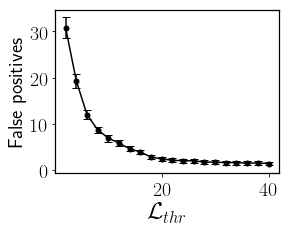

In [123]:
Lthr = np.linspace(2,40,20)

FPs = np.zeros(len(Lthr))
FPs_ste = np.zeros(len(Lthr))
for i in range(len(Lthr)):
    FPs[i] = np.mean(np.sum(m2lnLR_explos > Lthr[i],axis=1))
    FPs_ste[i] = np.std(np.sum(m2lnLR_explos > Lthr[i],axis=1))/np.sqrt(len(m2lnLR_explos))
    
plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4,3))

axis.errorbar(Lthr,FPs, yerr = FPs_ste, c = 'k', capsize = 4, fmt = 'o-',markersize=5)

axis.tick_params(labelsize = 20)
axis.spines['top'].set_linewidth(1.25)
axis.spines['left'].set_linewidth(1.25)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['right'].set_linewidth(1.25)
axis.set_ylabel(r"False positives",fontsize = 20)
axis.set_xlabel(r"$\mathcal{L}_{thr}$",fontsize=24)
#fig.savefig("figure_FPs_explo_crossvalidation.pdf")
plt.show()

# Compare Explo and a subsample of Acid dataset for 10 subsamples

In [12]:
niter = 10
w_dict_combined = combine_dicts(w_dict_explo,w_dict_dbsharppH,params,model_fit)
m2lnLR_dbsharppHs = np.zeros((niter,len(w_dict_combined)))
emps_dbsharppHs = np.zeros((niter,len(w_dict_combined)))
exps_dbsharppHs = np.zeros((niter,len(w_dict_combined)))

for n_ in range(niter):
    L = 0.8*len(data_dbsharppH_hmm)

    length_per_traj = len(data_dbsharppH_hmm)/len(lengths_dbsharppH_hmm)
    numtrajs = int(L/length_per_traj)

    sample_lengths = np.random.choice(len(lengths_dbsharppH_hmm),numtrajs, replace=False)
    nonsample_lengths = np.delete(np.arange(len(lengths_dbsharppH_hmm)),sample_lengths)

    lengths_dbsharppH_train = lengths_dbsharppH_hmm[sample_lengths]
    for i,l in enumerate(sample_lengths):
        first = np.sum(lengths_dbsharppH_hmm[:l])
        last = np.sum(lengths_dbsharppH_hmm[:l+1])
        if i==0:
            data_dbsharppH_train = data_dbsharppH_hmm[first:last]
        else:
            data_dbsharppH_train = np.concatenate((data_dbsharppH_train, data_dbsharppH_hmm[first:last]))
            
    lengths_explo = lengths_explo_hmm[:]
    data_explo = data_explo_hmm[:np.sum(lengths_explo)]

    Hexplo = -model_fit.score(data_explo,0)/len(data_explo) #entropy
    Yexplo = np.exp(model_fit._compute_log_likelihood(data_explo) + Hexplo)

    HdbsharppH_train =  -model_fit.score(data_dbsharppH_train,1)/len(data_dbsharppH_train) 
    YdbsharppH_train = np.exp(model_fit._compute_log_likelihood(data_dbsharppH_train) + HdbsharppH_train)

    m2lnLR_dbsharppH,emps_dbsharppH,exps_dbsharppH = compare_datasets(Yexplo, lengths_explo, YdbsharppH_train, lengths_dbsharppH_train, w_dict_explo, w_dict_dbsharppH, params,model_fit)
    
    m2lnLR_dbsharppHs[n_] = m2lnLR_dbsharppH
    emps_dbsharppHs[n_] = emps_dbsharppH
    exps_dbsharppHs[n_] = exps_dbsharppH

[ 66  67  68  69  70  71  72  73  75  76  77  80  82  84  85  89  91  92
  93  94  95  96  98  99 100 102 104 108 109 111 112 113 114 115 117 118
 119 121 125 130 136 138 142 145]
[ 66  67  68  69  70  71  72  73  75  76  77  80  82  84  85  89  91  92
  93  94  95  96  98  99 100 102 104 108 109 111 112 113 114 115 117 118
 119 121 125 130 136 138 142 145]
103 66 81
0058 0228 62.78 [5 5]
0012 0108 61.66 [0 0]
0037 0146 39.82 [0 5]
0041 0132 28.57 [5 0]
0690 0452 21.73 [2 3]
0010 0053 20.87 [0 5 5 5]
0347 0205 15.87 [4 3]
0057 0128 15.24 [2 3 1]
0056 0126 14.83 [6 6 6 5]
0075 0155 14.81 [0 4]
0071 0146 14.14 [1 2]
0159 0266 14.09 [3 6]
0354 0507 13.87 [4 4]
0056 0122 13.71 [4 0]
0045 0104 13.54 [5 5 5 5]
0088 0028 12.80 [3 3 3 3 3 3 3 3]
0139 0065 11.62 [3 4]
0060 0122 11.48 [5 4]
0119 0052 11.40 [3 3 3 1 3 3]
0231 0135 11.24 [3 1 3 3]
0061 0119 10.03 [6 6 6 6 6 6 6]
0211 0126 9.64 [3 1 3]
0037 0082 9.57 [6 6 5 6]
0059 0112 9.26 [3 3 3 3 3 3 3]
0027 0061 7.49 [2 2 3 2]
0040 0078 6.98 [

[ 66  67  68  69  70  71  72  73  75  76  77  80  82  84  85  89  91  92
  93  94  95  96  98  99 100 102 104 108 109 111 112 113 114 115 117 118
 119 121 125 130 136 138 142 145]
103 66 81
0058 0223 60.09 [5 5]
0012 0104 58.51 [0 0]
0037 0148 41.72 [0 5]
0041 0145 35.51 [5 0]
0010 0057 23.43 [0 5 5 5]
0058 0141 19.82 [3 3 3 3 3 3 3]
0356 0539 19.08 [4 4]
0075 0165 18.55 [0 4]
0055 0134 18.25 [4 0]
0348 0196 18.14 [4 3]
0233 0114 17.53 [3 1 3 3]
0139 0053 15.95 [3 4]
0160 0274 15.49 [3 6]
0061 0133 14.71 [2 3 1]
0045 0107 14.01 [5 5 5 5]
0057 0123 13.56 [6 6 6 5]
0060 0125 12.68 [5 4]
0508 0679 12.46 [6 6]
0072 0142 12.36 [1 2]
0010 0041 12.32 [6 6 6 5 6 6 6 6]
0029 0074 11.88 [5 6 5]
0038 0089 11.68 [6 6 5 6]
0686 0524 10.19 [2 3]
0027 0068 10.01 [2 2 3 2]
0026 0064 9.30 [5 5 5 6]
0081 0144 9.25 [6 5]
0165 0246 8.52 [6 6 6 6]
0050 0094 7.65 [0 6]
0336 0240 7.51 [3 3 3 1]
0040 0079 7.30 [5 6 6 5]
0097 0050 6.85 [3 3 3 3 3 1 3 3]
0062 0107 6.75 [6 6 6 6 6 6 6]
0071 0033 6.37 [3 3 2 3 3]

[ 66  67  68  69  70  71  72  73  75  76  77  80  82  84  85  89  91  92
  93  94  95  96  98  99 100 102 104 108 109 111 112 113 114 115 117 118
 119 121 125 130 136 138 142 145]
103 66 81
0011 0107 61.83 [0 0]
0057 0207 52.54 [5 5]
0036 0132 33.25 [0 5]
0010 0065 30.49 [0 5 5 5]
0040 0131 28.66 [5 0]
0226 0085 26.30 [3 1 3 3]
0672 0425 24.32 [2 3]
0058 0142 20.02 [2 3 1]
0340 0184 19.97 [4 3]
0346 0532 19.82 [4 4]
0073 0163 19.00 [0 4]
0095 0022 18.40 [3 3 3 3 3 1 3 3]
0056 0135 18.31 [3 3 3 3 3 3 3]
0158 0266 14.44 [3 6]
0010 0043 14.18 [6 6 6 5 6 6 6 6]
0324 0198 13.37 [3 3 3 1]
0055 0119 12.83 [6 6 6 5]
0044 0101 12.37 [5 5 5 5]
0058 0121 12.22 [5 4]
0037 0086 11.15 [6 6 5 6]
0497 0654 10.99 [6 6]
0184 0281 10.35 [6 6 6]
0039 0087 10.32 [5 6 6 5]
0055 0108 9.72 [4 0]
0205 0126 8.65 [3 1 3]
0028 0065 8.51 [5 6 5]
0059 0109 8.19 [6 6 6 6 6 6 6]
0049 0093 7.72 [0 6]
0135 0076 7.41 [3 4]
0025 0058 7.35 [5 5 5 6]
0027 0058 6.69 [2 2 3 2]
0029 0061 6.55 [5 5 6 5]
0038 0071 5.72 [3 3 1 3

# Get the eight flagged sequences for L_thr = 15 (10% FP rate)

In [122]:
Lthr_acid = 15
filtered_L = np.prod(m2lnLR_dbsharppHs > Lthr_acid, axis = 0)
filtered_num = np.prod(emps_dbsharppHs > exps_dbsharppHs, axis = 0)
filtered = filtered_L*filtered_num
np.set_printoptions(precision = 2)
filtered_indices = []
for i in range(len(filtered)):
    if filtered[i] == 1 and len(w_dict_combined[i]) > 1:
        print(i,w_dict_combined[i], "%.2f %d %d" %(np.mean(m2lnLR_dbsharppHs,axis=0)[i], np.mean(emps_dbsharppHs,axis=0)[i],np.mean(exps_dbsharppHs,axis=0)[i]))
        filtered_indices += [i]

35 [0 5] 35.74 135 36
38 [5 0] 34.60 140 39
51 [5 5] 55.84 210 55
71 [3 2 3 3] 90.84 101 5
83 [5 6 5 5] 24.96 49 6
84 [0 5 5 5] 24.07 56 9
86 [5 0 0 5] 46.06 63 5
94 [0 0] 66.63 111 11


# Test for markovianity and then print the motifs

In [54]:
transmat_, stationary_probs_ = compute_transmat(Yexplo)
mlnPs,emps,exps = test_for_markovianity(Yexplo,w_dict_explo,eps,p_d,transmat_, stationary_probs_)

1366 0387 inf [3 3 3 3 3 3 3 3 3 3]
0510 0050 inf [3 3 3 3 3 3 3 3 3 3 3 3 3 3]
3234 1797 208.01 [3 3 3 3 3 3 3]
9544 8327 42.33 [3 3 3 3]
0311 0153 28.23 [6 6 6 6 6 6 6]
0497 0290 27.64 [3 3 3 3 3 3 1 3]
0495 0297 25.07 [3 3 1 3 3 3 3 3]
1125 0824 22.72 [3 3 1 3 3 3]
1745 1377 21.12 [3 3 1 3 3]
2724 2289 18.50 [3 3 1 3]
4337 3859 13.96 [3 1 3]
0722 0554 11.12 [2 3 2]
1428 1224 7.94 [6 6 6 6]
0346 0254 7.28 [2 3 2 3]
0256 0181 6.70 [1 1 1 1]
0160 0110 5.06 [2 2 2 2]
0115 0082 3.21 [5 5 5 5]
39758 39308 2.72 [3]
0099 0074 2.19 [6 5 6 5]
0072 0054 1.72 [5 5 6 5]
0100 0078 1.72 [5 6 5 6]
0242 0209 1.57 [5 6 5]
2547 2447 1.39 [6 6 6]
23359 23128 1.13 [3 3]
0116 0101 0.84 [6 5 5 5]
0108 0098 0.49 [5 6 6 5]
0273 0258 0.44 [6 6 5 6]
0349 0338 0.28 [6 6 6 5]
15439 15375 0.25 [1]
0030 0028 0.18 [0 4 1]
2266 2248 0.15 [1 2]
0110 0106 0.15 [5 5 5 6]
2139 2122 0.15 [4 3]
0004 0004 0.11 [1 0 4 1]
1063 1056 0.08 [3 0]
1059 1053 0.07 [0 3]
0267 0265 0.06 [6 5 6 6]
5012 5006 0.03 [2 3]
1218 1214 0.03 

In [61]:
sorted_= np.argsort(-mlnPs)
for w in sorted_:
    if len(w_dict_explo[w]) > 1:
    #if emps[w] > exps[w] and 10**(-mlnPs[w]) < 1e-3:
        chrs = []
        for c in w_dict_explo[w]:
            if c == 0:
                chrs += ['O']
            elif c==1:
                chrs += ['t']
            elif c==2:
                chrs += ['T']
            elif c==3:
                chrs += ['f']
            elif c==4:
                chrs += ['L']
            elif c==5:
                chrs += ['b']
            elif c==6:
                chrs += ['F']
                
            str_ = ''.join(chrs)
        print("%.2f" %mlnPs[w])
        #print("%d"%(exps[w]*len(Yexplo)))
        #print("%d"%(emps[w]*len(Yexplo)))
        #print(str_)
        #print(str_, "%05d %05d %05.2f"%(emps[w]*len(Yexplo),exps[w]*len(Yexplo),mlnPs[w]))    

inf
inf
208.01
42.33
28.23
27.64
25.07
22.72
21.12
18.50
13.96
11.12
7.94
7.28
6.70
5.06
3.87
3.21
2.19
1.79
1.74
1.72
1.72
1.66
1.57
1.39
1.15
1.13
0.84
0.49
0.48
0.44
0.40
0.40
0.33
0.29
0.28
0.25
0.18
0.17
0.15
0.15
0.15
0.14
0.11
0.11
0.10
0.08
0.08
0.07
0.06
0.05
0.05
0.03
0.03
0.01
0.01
0.01
0.00


# Same as above but for acid

In [109]:
transmat_, stationary_probs_ = compute_transmat(YdbsharppH)
mlnPs,emps,exps = test_for_markovianity(YdbsharppH,w_dict_dbsharppH,eps,p_d,transmat_, stationary_probs_)

0497 0033 inf [3 3 3 3 3 3 3 3 3 3 3 3 3 3]
0751 0093 inf [3 3 3 3 3 3 3 3 3 3 3 3]
0334 0012 inf [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
1860 0719 278.21 [3 3 3 3 3 3 3 3]
3266 1990 155.38 [3 3 3 3 3 3]
0653 0294 71.86 [6 6 6 6 6 6 6]
6533 5506 44.26 [3 3 3 3]
0059 0004 43.87 [6 6 6 6 6 6 6 6 6 6 6 6 6 6]
0290 0166 17.45 [3 3 3 1 3 3 3 3]
0285 0165 16.56 [3 3 3 3 3 1 3 3]
2167 1821 14.89 [6 6 6 6]
0641 0460 14.89 [3 3 3 1 3 3]
0960 0767 10.83 [3 3 1 3 3]
0456 0342 8.42 [2 3 2]
0184 0123 6.54 [3 2 3 2]
0316 0234 6.45 [5 5 5 5]
0162 0107 6.09 [1 1 1 1]
0087 0049 5.94 [5 6 6 6 6 6 6 6]
0083 0047 5.67 [6 6 6 6 6 6 6 5]
0139 0092 5.30 [2 2 2 2]
1448 1290 4.87 [3 1 3 3]
0056 0030 4.79 [6 6 6 5 6 6 6 6]
0405 0330 4.18 [5 6 5]
0148 0107 3.81 [5 5 6 5]
0106 0072 3.68 [0 5 5 5]
0451 0384 3.03 [3 1 3 1]
0404 0343 2.87 [6 6 5 6]
0142 0108 2.70 [6 5 6 5]
0101 0073 2.62 [2 2 3 2]
3510 3340 2.55 [6 6 6]
26181 25818 2.42 [3]
0143 0111 2.41 [5 6 5 6]
0040 0025 2.34 [5 0 0 5]
0072 0050 2.30 [5 0 5 5]
0140 01

In [113]:
sorted_= np.argsort(-mlnPs)
for w in sorted_:
    if len(w_dict_dbsharppH[w]) > 1:
    #if emps[w] > exps[w] and 10**(-mlnPs[w]) < 1e-3:
        chrs = []
        for c in w_dict_dbsharppH[w]:
            if c == 0:
                chrs += ['O']
            elif c==1:
                chrs += ['t']
            elif c==2:
                chrs += ['T']
            elif c==3:
                chrs += ['f']
            elif c==4:
                chrs += ['L']
            elif c==5:
                chrs += ['b']
            elif c==6:
                chrs += ['F']
                
            str_ = ''.join(chrs)
        #print(str_)
        #print("%.2f" %mlnPs[w])
        #print("%d"%(emps[w]*len(YdbsharppH)))
        print("%d"%(exps[w]*len(YdbsharppH)))
        #print(str_, "%05d %05d %05.2f"%(emps[w]*len(YdbsharppH),exps[w]*len(YdbsharppH),mlnPs[w]))    

33
93
12
719
1990
294
5506
4
166
165
1821
460
767
342
123
234
107
49
47
92
1290
30
330
107
72
1917
384
343
108
73
3340
111
25
50
110
53
813
13
47
724
351
28
2010
15
15226
562
165
1954
6126
425
1934
608
1053
1646
507
562
568
988
1889
771
430
723
216
328
848
441
345
542
1274
363
651
1674
895
337


# This is to generate files used in the "Zebrafish_larvae_analysis_acid_data_final" notebook

## First three cells are for acid and the four after that are for explo

In [98]:
data_explo_hmm = np.load("data_explo_hmm.npy")
data_dbsharppH_hmm = np.load("data_dbsharppH_hmm.npy")

lengths_explo_hmm = np.load("lengths_explo_hmm.npy")
lengths_dbsharppH_hmm = np.load("lengths_dbsharppH_hmm.npy")

model_fit = GMM_model(7)

means_ = np.load("acid_means.npy")
covars_ = np.load("acid_covars.npy")
weights_ = np.load("acid_weights.npy")
model_fit._read_params(means_,covars_,weights_)

lengths_dbsharppH = lengths_dbsharppH_hmm
data_dbsharppH = data_dbsharppH_hmm

HdbsharppH = -model_fit.score(data_dbsharppH,1)/len(data_dbsharppH) #entropy
YdbsharppH = np.exp(model_fit._compute_log_likelihood(data_dbsharppH))/np.exp(-HdbsharppH)

w_MLs_dbsharppH,wss_dbsharppH,lss_dbsharppH = decode(YdbsharppH,lengths_dbsharppH,w_dict_combined,params)

In [118]:
chars_out_dbsharppH = []
words_out_dbsharppH = []
words_lnP_out_dbsharppH = []
abnormal_out_dbsharppH = []
lengths_out_dbsharppH = []
currsum = 0
for i,w_ML in enumerate(w_MLs_dbsharppH):
    temp += len(w_ML)
    chars_out_dbsharppH += w_ML
    for k,l in enumerate(lss_dbsharppH[i]):
        currsum += l
        lengths_out_dbsharppH += [currsum]
        word = wss_dbsharppH[i][k]
        if word in filtered_indices:
            flag = 1
        else:
            flag = 0
        for j in range(l): 
            words_lnP_out_dbsharppH += [np.mean(m2lnLR_dbsharppHs,axis=0)[word]]
            words_out_dbsharppH += [word]
            abnormal_out_dbsharppH += [flag]
chars_out_dbsharppH = np.array(chars_out_dbsharppH)
words_out_dbsharppH = np.array(words_out_dbsharppH)
words_lnP_out_dbsharppH = np.array(words_lnP_out_dbsharppH)
abnormal_out_dbsharppH = np.array(abnormal_out_dbsharppH)
lengths_out_dbsharppH = np.array(lengths_out_dbsharppH)

In [119]:
filename = "dbsharppH_data_segmented"
np.save(filename + "_bouttypes",chars_out_dbsharppH)
np.save(filename + "_words",words_out_dbsharppH)
np.save(filename + "_words_lnP",words_lnP_out_dbsharppH)
np.save(filename + "_abnormal",abnormal_out_dbsharppH)
np.save(filename + "_lengths", lengths_out_dbsharppH)

In [101]:
data_explo_hmm = np.load("data_explo_hmm.npy")
data_dbsharppH_hmm = np.load("data_dbsharppH_hmm.npy")

lengths_explo_hmm = np.load("lengths_explo_hmm.npy")
lengths_dbsharppH_hmm = np.load("lengths_dbsharppH_hmm.npy")

model_fit = GMM_model(7)

means_ = np.load("acid_means.npy")
covars_ = np.load("acid_covars.npy")
weights_ = np.load("acid_weights.npy")
model_fit._read_params(means_,covars_,weights_)

lengths_explo = lengths_explo_hmm
data_explo = data_explo_hmm

Hexplo = -model_fit.score(data_explo,1)/len(data_explo) #entropy
Yexplo = np.exp(model_fit._compute_log_likelihood(data_explo))/np.exp(-Hexplo)

w_MLs_explo,wss_explo,lss_explo = decode(Yexplo,lengths_explo,w_dict_explo,params)

In [102]:
transmat_, stationary_probs_ = compute_transmat(Yexplo)
mlnPs,emps,exps = test_for_markovianity(Yexplo,w_dict_explo,eps,p_d,transmat_, stationary_probs_)

1368 0390 inf [3 3 3 3 3 3 3 3 3 3]
0511 0050 inf [3 3 3 3 3 3 3 3 3 3 3 3 3 3]
3237 1805 206.12 [3 3 3 3 3 3 3]
9550 8341 41.71 [3 3 3 3]
0498 0291 27.48 [3 3 3 3 3 3 1 3]
0314 0157 27.41 [6 6 6 6 6 6 6]
0495 0298 24.87 [3 3 1 3 3 3 3 3]
1127 0826 22.56 [3 3 1 3 3 3]
1748 1379 21.12 [3 3 1 3 3]
2726 2291 18.45 [3 3 1 3]
4336 3859 13.89 [3 1 3]
0720 0551 11.25 [2 3 2]
1437 1240 7.42 [6 6 6 6]
0345 0253 7.36 [2 3 2 3]
0253 0178 6.88 [1 1 1 1]
0158 0107 5.37 [2 2 2 2]
0114 0082 3.17 [5 5 5 5]
39738 39279 2.80 [3]
0098 0073 2.17 [6 5 6 5]
0072 0054 1.74 [5 5 6 5]
0099 0078 1.73 [5 6 5 6]
0240 0208 1.58 [5 6 5]
2558 2467 1.20 [6 6 6]
23359 23130 1.11 [3 3]
0115 0100 0.86 [6 5 5 5]
0108 0098 0.49 [5 6 6 5]
0272 0257 0.43 [6 6 5 6]
0350 0339 0.25 [6 6 6 5]
15442 15389 0.19 [1]
0110 0105 0.17 [5 5 5 6]
0030 0028 0.17 [0 4 1]
2140 2123 0.15 [4 3]
0004 0004 0.11 [1 0 4 1]
2285 2273 0.09 [2 2]
1063 1055 0.09 [3 0]
1058 1052 0.07 [0 3]
2275 2266 0.07 [1 2]
0267 0264 0.06 [6 5 6 6]
5007 4998 0.05 

In [116]:
chars_out_explo = []
words_out_explo = []
words_lnP_out_explo = []
lengths_out_explo = []
currsum = 0
for i,w_ML in enumerate(w_MLs_explo):
    temp += len(w_ML)
    chars_out_explo += w_ML
    for k,l in enumerate(lss_explo[i]):
        currsum += l
        lengths_out_explo += [currsum]
        word = wss_explo[i][k]
        for j in range(l): 
            words_lnP_out_explo += [mlnPs[word]]
            words_out_explo += [word]
chars_out_explo = np.array(chars_out_explo)
words_out_explo = np.array(words_out_explo)
words_lnP_out_explo = np.array(words_lnP_out_explo)
lengths_out_explo = np.array(lengths_out_explo)

In [117]:
filename = "explo_data_segmented"
np.save(filename + "_bouttypes",chars_out_explo)
np.save(filename + "_words",words_out_explo)
np.save(filename + "_words_lnP",words_lnP_out_explo)
np.save(filename + "_lengths",lengths_out_explo)